**Install dependencies**

In [ ]:
# %%capture
# !pip install -U torch torchvision torchaudio torcheval
# !pip install -U transformers accelerate jupyter timm opencv-python tqdm;
# !pip install -U cjm_pil_utils cjm_pytorch_utils

**Import dependencies**

In [2]:
# Import necessary modules from the standard library
import random
from pathlib import Path

# Import the Image module from the PIL (Python Imaging Library) package
from PIL import Image

# Import numpy
import numpy as np

# Import torch
import torch

# Import the `tqdm` module
from tqdm.auto import tqdm

In [3]:
from cjm_pil_utils.core import stack_imgs, get_img_files
from cjm_pytorch_utils.core import get_torch_device

**Select model type**

In [4]:
# model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
# model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)

Using cache found in /home/innom-dt/.cache/torch/hub/intel-isl_MiDaS_master


**Set device and data type**

In [5]:
device = get_torch_device()
dtype = torch.float16 if device == 'cuda' else torch.float32
device, dtype

('cuda', torch.float16)

**Set compute backend and floating point precision**

In [6]:
# Move the 'midas' model to the device specified in the 'device' variable
midas.to(device=device, dtype=dtype)

# Set the 'midas' model to evaluation mode
midas.eval();

**Define input transforms**

In [7]:
# Load the 'transforms' module from the 'intel-isl/MiDaS' library
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

# Set the input transforms based on the chosed 'model_type'
if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    # Set the 'transform' variable to the 'dpt_transform' function
    transform = midas_transforms.dpt_transform
else:
    # Set the 'transform' variable to the 'small_transform' function
    transform = midas_transforms.small_transform


# Print the list of input transforms
transform

Using cache found in /home/innom-dt/.cache/torch/hub/intel-isl_MiDaS_master


Compose(
    <function transforms.<locals>.<lambda> at 0x7ff7b422d090>
    <function transforms.<locals>.<lambda> at 0x7ff7b422d120>
)

**Remove the default Resize transform**

In [8]:
# Remove the default 'Resize' transform from the list of transforms
transform.transforms.pop(1)

# Print the modified list of input transforms
transform

Compose(
    <function transforms.<locals>.<lambda> at 0x7ff7b422d090>
    <function transforms.<locals>.<lambda> at 0x7ff7b422d120>
)

**Define path to image dataset**

In [9]:
# Set the path for the images directory
# img_dir = Path('./train_dir/cp2077-steelbook-custom-768/')
# dataset_path = Path(f"./train_dir/cp2077-steelbook-custom-768-and-text2img")
dataset_path = Path("/mnt/980_1TB_2/Datasets/Pexels_Full_1056p")

# Set the path for the images directory
img_dir = Path(dataset_path/"images/")

**Get image file paths**

In [10]:
# Get a list of the paths to the images in the images directory
img_paths = get_img_files(img_dir)

# Print the number of images in the images directory
print(len(img_paths))

109971


**Create image path dictionary**

In [11]:
# Create a dictionary mapping image names to image paths
img_path_dict = {path.stem.split('-')[-1] : path for path in img_paths}

img_ids = list(img_path_dict.keys())

**Select a sample image**

Name: 2498440


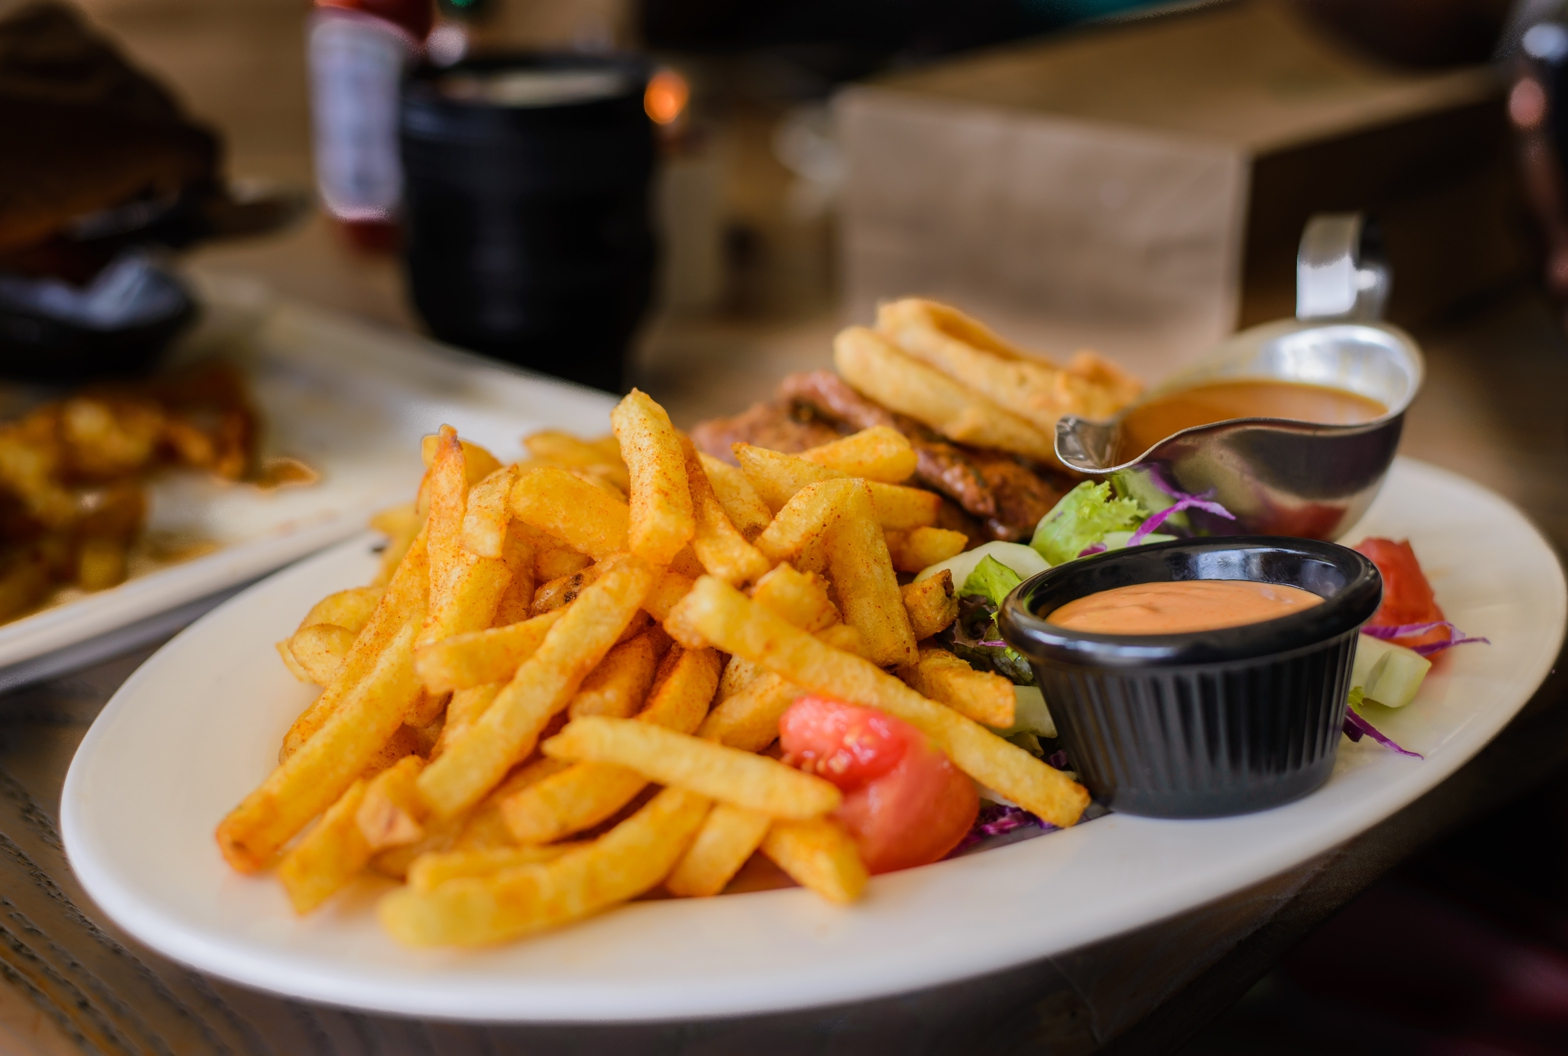

In [12]:
# Choose a random image ID from the list of image IDs
img_id = random.choice(img_ids)

img_id = '2498440'

print(f"Name: {img_id}")

# Open the image located at the path in the img_path_dict with the key of the current img_id
image = Image.open(img_path_dict[img_id])

# Display the image
image

**Define a function to convert an image to a depth map**

In [13]:
def img_to_depth(image, transform, device, model):
    """
    Converts an image to a depth map using a given model and transform function.
    
    Parameters:
    - image (PIL.Image): The image to be converted.
    - transform (function): The transform function to be applied to the image.
    - device (str): The device on which the model should run ('cpu', 'cuda', or 'mps').
    - model (torch.nn.Module): The model to be used for conversion.
    
    Returns:
    - depth_map (PIL.Image): The depth map created from the input image.
    """
    # Convert the image to a numpy array
    img_array = np.array(image)
    
    # Apply the transform function to the image array and move the result to the specified device
    input_batch = transform(img_array).to(device).type(list(model.parameters())[0].dtype)
    
    # Run the model in evaluation mode and get the prediction
    with torch.no_grad():
        depth_map = model(input_batch).squeeze()
        
    # If the device is a GPU (CUDA), empty the GPU cache
    if device == "cuda":
        torch.cuda.empty_cache()
    
    # Normalize the depth map between 0 and 1
    depth_min = torch.amin(depth_map, dim=[0, 1], keepdim=True)
    depth_max = torch.amax(depth_map, dim=[0, 1], keepdim=True)
    depth_map = (depth_map - depth_min) / (depth_max - depth_min)
    
    # Convert the depth map tensor to a numpy array
    depth_map = depth_map.cpu().detach().numpy()
    
    # Convert the depth map numpy array to a PIL image
    return Image.fromarray((depth_map*255).astype(np.uint8))

**Convert image to depth map**

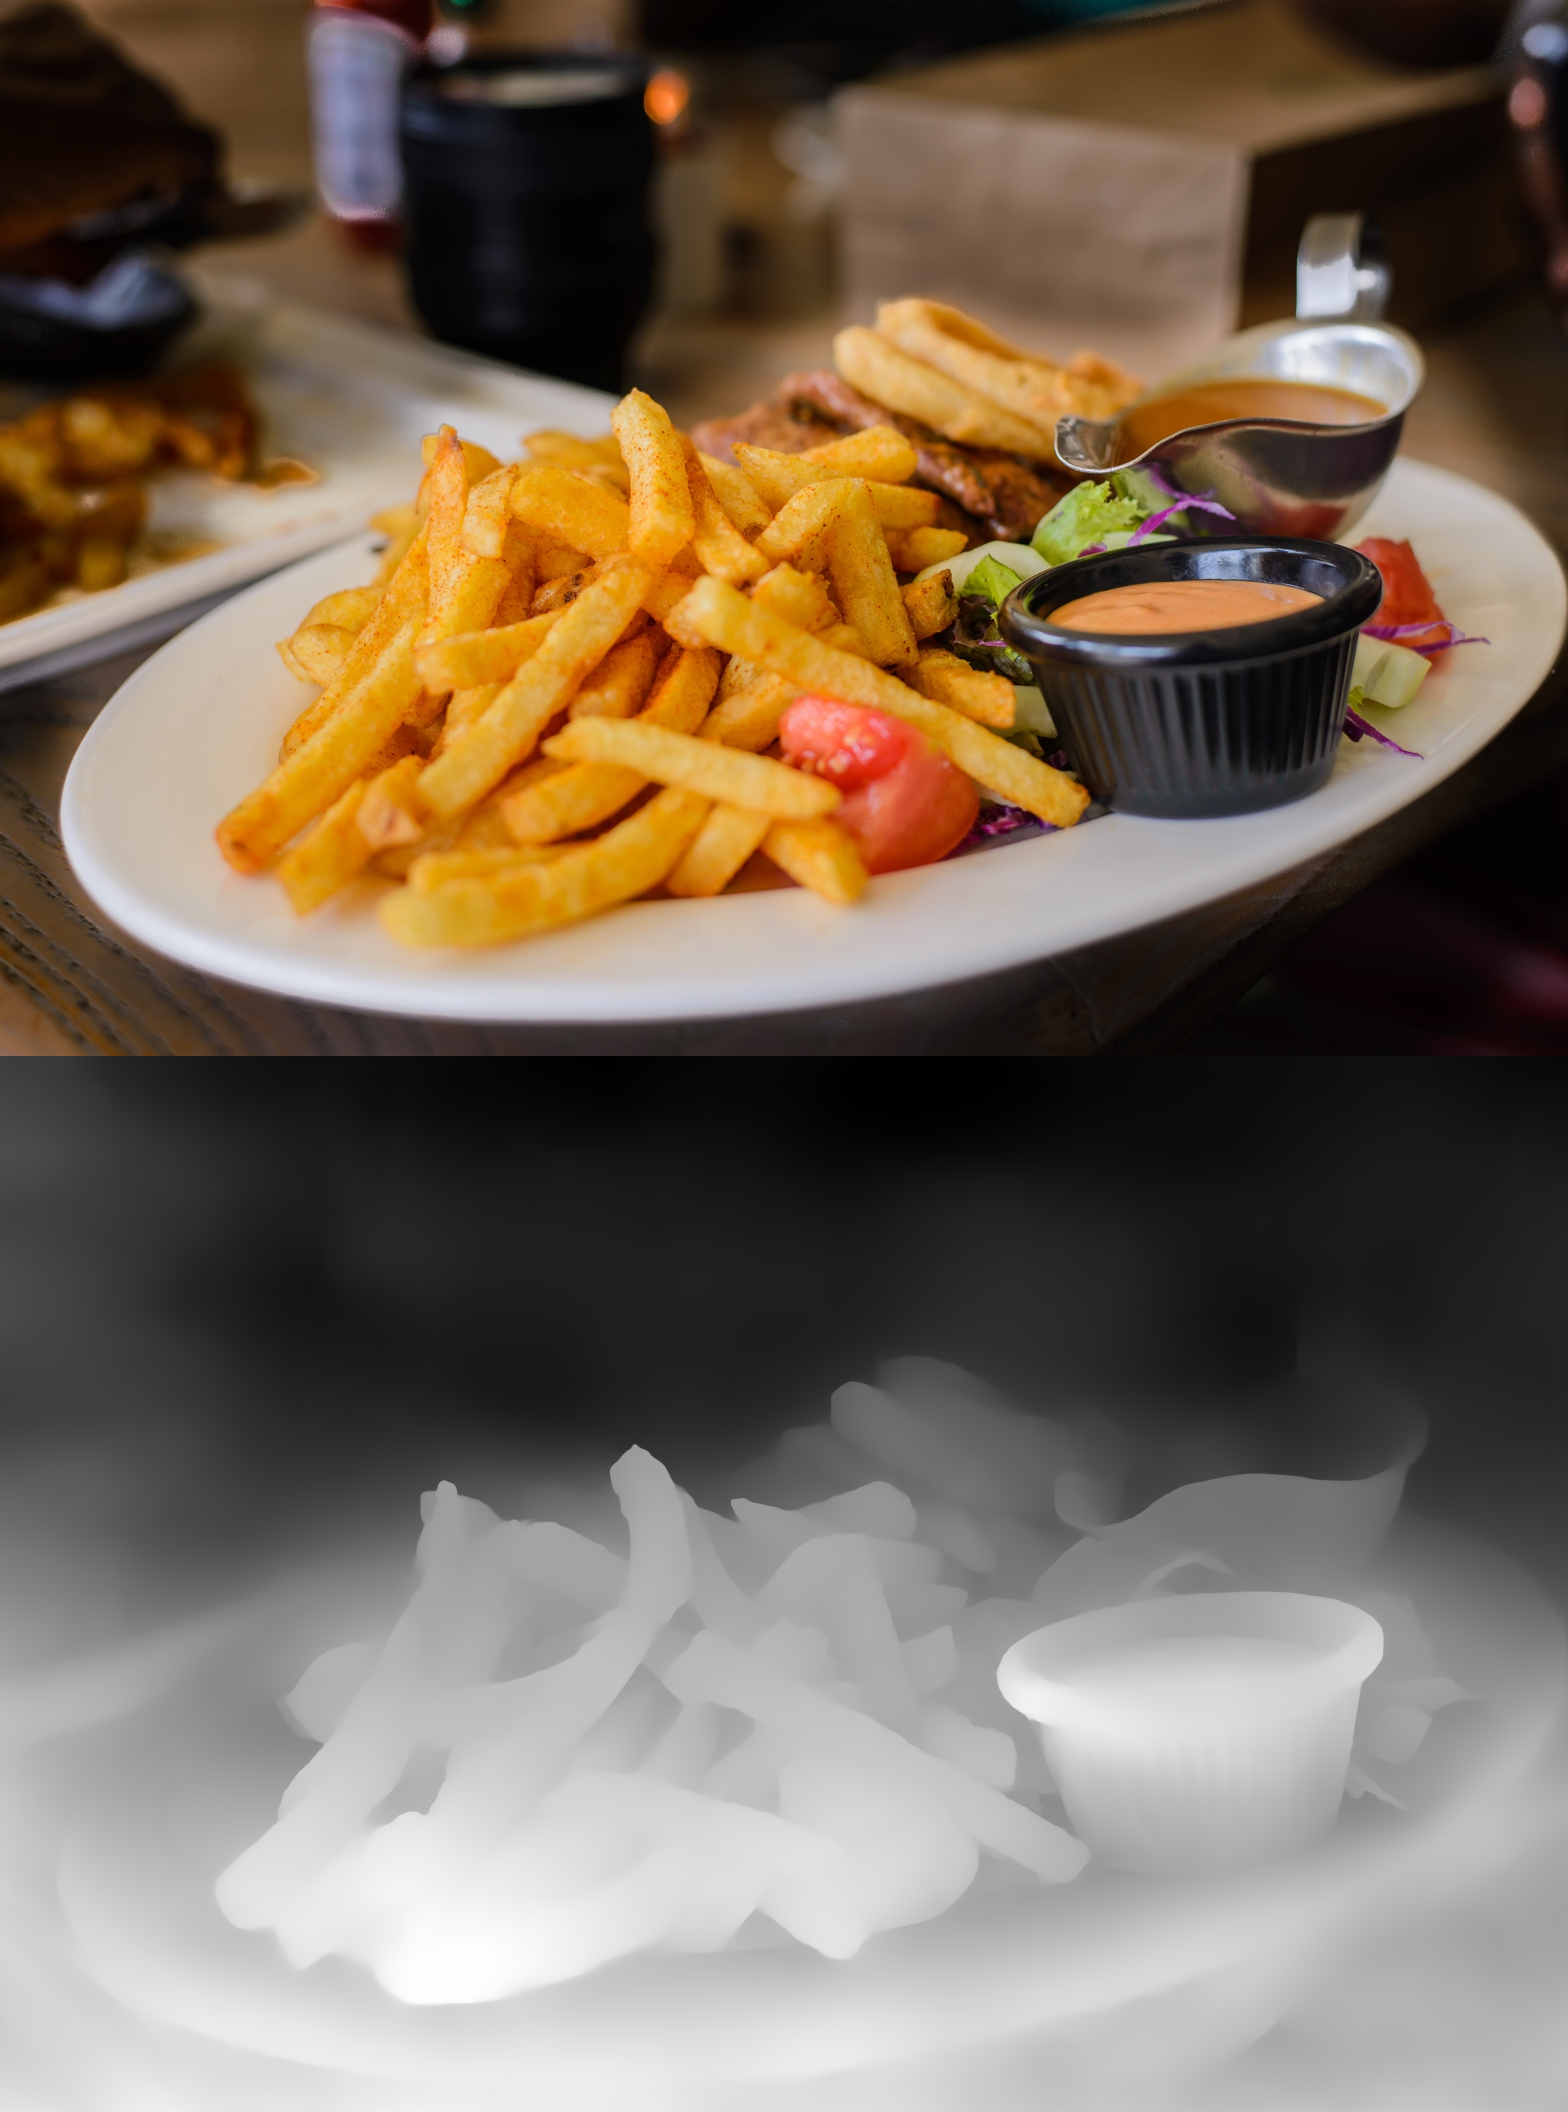

In [14]:
# Convert the sample image to a depth map using the 'img_to_depth' function
stack_imgs([image, img_to_depth(image, transform, device, midas)])

**Define funtion to convert an image to a depth map and save it to disk**

In [15]:
def array_func(img_id, img_path_dict, transform, device, model, save_dir, quality=100):
    """
    Converts an image to a depth map and saves the depth map to a specified directory.
    
    Parameters:
    - img_id (int or str): The key for the image path in the img_path_dict.
    - img_path_dict (dict): A dictionary with keys as image IDs and values as image file paths.
    - transform (function): The transform function to be applied to the image.
    - device (str): The device on which the model should run ('cpu', 'cuda', or 'mps').
    - model (torch.nn.Module): The model to be used for conversion.
    - save_dir (str or pathlib.Path): The directory where the depth map should be saved.
    - quality (int, optional): The quality of the saved image (only applicable to JPEG format). Default is 100.
    """
    # Open the image located at the path in the img_path_dict with the key of the current img_id
    img = Image.open(img_path_dict[img_id])
    
    # Convert the image to a depth map using the 'img_to_depth' function
    depth_img = img_to_depth(img, transform, device, midas)
    
    # Construct the path where the depth map should be saved.
    save_path = Path(save_dir/f"depth-{img_id}.{img.format.lower()}")
    
    # Save the depth map to the specified directory using the original image format and quality settings.
    depth_img.save(save_path, img.format, quality=quality)

**Define save directory**

In [16]:
# Create a `Path` object for the directory that will be used to save the images.
save_dir = Path(f"{img_dir.parent}/depth")

# Create the directory if it does not already exist.
save_dir.mkdir(parents=True, exist_ok=True)

# Print the `Path` object for the save directory.
save_dir

PosixPath('/mnt/980_1TB_2/Datasets/Pexels_Full_1056p/depth')

**Test array function**

In [17]:
# Convert an image to a depth map and save the depth map to the specified directory
array_func(img_id, img_path_dict, transform, device, midas, save_dir)

**Generate depth maps for image dataset**

In [ ]:
# Iterate through the list of image IDs
for img_id in tqdm(img_ids):
    # Convert an image to a depth map and save the depth map to the specified directory
    array_func(img_id, img_path_dict, transform, device, midas, save_dir)

In [ ]:
stop

### References
[Towards Robust Monocular Depth Estimation: Mixing Datasets for Zero-shot Cross-dataset Transfer](https://arxiv.org/abs/1907.01341)

[Vision Transformers for Dense Prediction](https://arxiv.org/abs/2103.13413)

In [ ]:
@article{Ranftl2020,
	author    = {Ren\'{e} Ranftl and Katrin Lasinger and David Hafner and Konrad Schindler and Vladlen Koltun},
	title     = {Towards Robust Monocular Depth Estimation: Mixing Datasets for Zero-shot Cross-dataset Transfer},
	journal   = {IEEE Transactions on Pattern Analysis and Machine Intelligence (TPAMI)},
	year      = {2020},
}

In [ ]:
@article{Ranftl2021,
	author    = {Ren\'{e} Ranftl and Alexey Bochkovskiy and Vladlen Koltun},
	title     = {Vision Transformers for Dense Prediction},
	journal   = {ArXiv preprint},
	year      = {2021},
}